# Introduction

The data is estimation of SalePrice from the data that we were given.
The features engineering is pretty much:

1. Imputing missing values by proceeding sequentially through the data

2. Transforming some variables.

3. Deleting those variables that are less correlating or negatively correlating.

3. Logarithmic Transformation of skewed features.

4. Standardizing variables

5. Designing various models and comparing them using mean square error.

# Project Objective

The main goal is to properly assemble, clean, and manage a set of raw data files about residential real estate properties; once you have the integrated and cleansed data set, use programming to build two (or more) types of supervised predictive algorithms (at least including linear regression and k-Nearest-Neighbor; you are encouraged but not required to self-acquire knowledge and skills of new models beyond the course’s coverage) in order to estimate the sales price of a list of one-hundred (100) houses in a holdout sample.

# Background and Goal

Imagine that you are an investment consultant helping your very important clients purchase residential properties in the city where the Raw data files were collected. You have hand-picked 100 properties that appear to be attracting most of your clients’ attention. The broker of the properties has given you the relevant information in your Score data set, including many assessed values of the houses. However, this Score data set does not contain the final sales prices of the properties, because they are not known when you help your clients, are they? Our job is to predict the final sales prices of these homes as close to reality as possible before they even happen! This is so that your clients will not leave too much money on the table by offering too high a price. Specifically, you will need to use the programming skills and techniques that you learned and will learn in the process of doing this project to train and implement at least two (2) data mining algorithms to predict the SalePrice.

# Data

We are given four (4) Raw data files containing information from an anonymous United States city assessor’s office that is located in the North West region. The values in the data files are for individual residential real estate properties sold in that city over a time period of 4 years. Descriptions of the variables and the different data files are given below. These raw data files share one common column—PID (Property ID), which is a string of 10 numbers denoting the unique IDs of the real estate property; We will use PID as a “primary key” as if in a database, and join the several data files into an integrated data set (data-frame object).

# Part 0: Import all necessary libraries

**Imports**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.metrics import mean_squared_error, make_scorer
from scipy.stats import skew
from IPython.display import display

Load Data

In [2]:
df_hf = pd.read_csv("House_Feature.csv")
df_ps1 = pd.read_csv("Property_Survey_1.csv")
df_ps2 = pd.read_csv("Property_Survey_2.csv")
df_ps = pd.concat([df_ps1, df_ps2])
df_qa = pd.read_csv("Quality_Assessment.csv")

df_train=pd.merge(pd.merge(df_hf,df_ps,on='PID'),df_qa,on='PID')
df_test = pd.read_csv("Score_Data-No_Sale_Price.csv")

Useful function

In [3]:
def get_best_score(grid):
    
    best_score = np.sqrt(-grid.best_score_)
    print(best_score)    
    print(grid.best_params_)
    print(grid.best_estimator_)
    
    return best_score

# Part 1: Exploratory Data Analysis

Let's get a first overview of the train and test dataset  
How many rows and columns are there?  
What are the names of the features (columns)?   
How many values are missing?  
The **shape** and **info** methods answer these questions  
**head** displays some rows of the dataset  
**describe** gives a summary of the statistics

In [4]:
# Drop PID column since it is unnecessary for the prediction process
train_pid=df_train['PID']
test_pid=df_test['PID']
df_train.drop("PID", axis = 1, inplace = True)
df_test.drop("PID", axis = 1, inplace = True)

In [5]:
print(df_train.shape)
print("*"*50)
print(df_test.shape)

(2370, 27)
**************************************************
(100, 26)


In [6]:
print(df_train.info())
print("*"*50)
print(df_test.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2370 entries, 0 to 2369
Data columns (total 27 columns):
YearBuilt           2370 non-null int64
YearRemodel         2370 non-null int64
VeneerExterior      2370 non-null int64
BsmtFinTp           2370 non-null int64
BsmtFinSqft         2370 non-null int64
BsmtUnfinSqft       2370 non-null int64
HeatingQC           2370 non-null int64
FstFlrSqft          2370 non-null int64
SecFlrSqft          2370 non-null int64
AbvGrndLiving       2370 non-null int64
FullBathBsmt        2370 non-null int64
HalfBathHouse       2370 non-null int64
FullBathHouse       2370 non-null int64
BdrmAbvGrnd         2370 non-null int64
RmAbvGrnd           2370 non-null int64
Fireplaces          2370 non-null int64
GarageTp            2370 non-null int64
GarageCars          2370 non-null int64
GarageArea          2370 non-null int64
WdDckSqft           2370 non-null int64
OpenPrchSqft        2370 non-null int64
SalePrice           2370 non-null int64
LotArea      

df_train has 28 columns (26 features + id and target SalePrice) and 2370 entries. 
df_test has 27 columns (26 features + id) and 100 entries. 
There is lots of info that is probably related to the SalePrice like the area, the neighborhood, the condition and quality.
Maybe other features are not so important for predicting the target, also there might be a strong correlation for some of the features (like GarageCars and GarageArea). For some columns many values are missing: some entries in df_test.

Fill mising values in df_test

In [7]:
df_test.fillna(df_test.mean(), inplace=True)

Analysis of data

In [8]:
df_train.head()

,YearBuilt,YearRemodel,VeneerExterior,BsmtFinTp,BsmtFinSqft,BsmtUnfinSqft,HeatingQC,FstFlrSqft,SecFlrSqft,AbvGrndLiving,...,GarageCars,GarageArea,WdDckSqft,OpenPrchSqft,SalePrice,LotArea,LotShape,BldgTp,OverallQuality,OverallCondition
0,1960,1960,112,1,639,441,0,1656,0,1656,...,2,528,210,62,215000,31770,0,1,6,5
1,1961,1961,0,1,468,270,1,896,0,896,...,1,730,140,0,105000,11622,1,1,5,6
2,1958,1958,108,1,923,406,1,1329,0,1329,...,1,312,393,36,172000,14267,0,1,6,6
3,1968,1968,0,1,1065,1045,3,2110,0,2110,...,2,522,0,0,244000,11160,1,1,7,5
4,1997,1998,0,1,791,137,2,928,701,1629,...,2,482,212,34,189900,13830,0,1,5,5


In [9]:
df_train.describe()

,YearBuilt,YearRemodel,VeneerExterior,BsmtFinTp,BsmtFinSqft,BsmtUnfinSqft,HeatingQC,FstFlrSqft,SecFlrSqft,AbvGrndLiving,...,GarageCars,GarageArea,WdDckSqft,OpenPrchSqft,SalePrice,LotArea,LotShape,BldgTp,OverallQuality,OverallCondition
count,2370.000000,2370.000000,2370.000000,2370.000000,2370.000000,2370.000000,2370.000000,2370.000000,2370.000000,2370.000000,...,2370.000000,2370.000000,2370.000000,2370.000000,2370.000000,2370.000000,2370.000000,2370.000000,2370.000000,2370.000000
mean,1970.570886,1984.086920,88.143882,0.704641,429.805907,557.101688,2.153586,1116.442616,325.198734,1446.174262,...,1.718987,457.978903,91.650633,46.002532,173730.772574,9700.865401,0.643460,0.877215,6.050633,5.630380
std,30.109415,20.694221,158.718586,0.456300,408.779757,410.685375,0.944222,344.282409,406.198426,445.597554,...,0.708998,197.608559,120.616635,64.245617,64080.843305,6153.729681,0.479078,0.328259,1.252423,1.095717
min,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,407.000000,0.000000,407.000000,...,0.000000,0.000000,0.000000,0.000000,12789.000000,1300.000000,0.000000,0.000000,2.000000,1.000000
25%,1953.000000,1965.000000,0.000000,0.000000,0.000000,239.250000,1.000000,864.000000,0.000000,1105.500000,...,1.000000,312.000000,0.000000,0.000000,129900.000000,7200.000000,0.000000,1.000000,5.000000,5.000000
50%,1972.000000,1993.000000,0.000000,1.000000,378.000000,470.000000,3.000000,1056.000000,0.000000,1397.000000,...,2.000000,463.000000,0.000000,25.000000,159000.000000,9316.000000,1.000000,1.000000,6.000000,5.000000
75%,1999.000000,2003.000000,144.000000,1.000000,715.500000,792.000000,3.000000,1331.500000,688.750000,1688.750000,...,2.000000,572.000000,168.000000,68.000000,207000.000000,11235.000000,1.000000,1.000000,7.000000,6.000000
max,2010.000000,2010.000000,1600.000000,1.000000,2085.000000,2140.000000,3.000000,2898.000000,1721.000000,3608.000000,...,5.000000,1488.000000,736.000000,547.000000,475000.000000,159000.000000,1.000000,1.000000,10.000000,9.000000


In [10]:
df_test.head()

,LotArea,LotShape,BldgTp,OverallQuality,OverallCondition,YearBuilt,YearRemodel,VeneerExterior,BsmtFinTp,BsmtFinSqft,...,HalfBathHouse,FullBathHouse,BdrmAbvGrnd,RmAbvGrnd,Fireplaces,GarageTp,GarageCars,GarageArea,WdDckSqft,OpenPrchSqft
0,8987,1,1,8,5,2005,2006,226.0,0,0,...,0,2,2.0,6.0,1,3,3,880,144,0
1,9215,1,1,7,5,2009,2010,0.0,0,0,...,0,2,2.0,4.0,0,3,2,676,0,136
2,8640,1,1,7,5,2009,2009,0.0,1,24,...,1,2,3.0,7.0,0,3,2,614,169,45
3,6762,1,1,7,5,2006,2006,24.0,1,686,...,0,2,2.0,6.0,0,3,2,632,105,61
4,10402,0,1,7,5,2009,2009,0.0,0,0,...,0,2,3.0,6.0,0,3,3,740,0,36


In [11]:
df_test.describe()

,LotArea,LotShape,BldgTp,OverallQuality,OverallCondition,YearBuilt,YearRemodel,VeneerExterior,BsmtFinTp,BsmtFinSqft,...,HalfBathHouse,FullBathHouse,BdrmAbvGrnd,RmAbvGrnd,Fireplaces,GarageTp,GarageCars,GarageArea,WdDckSqft,OpenPrchSqft
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.00000,100.000000,100.000000,100.000000,...,100.000000,100.000000,100.000000,100.000000,100.000000,100.00000,100.000000,100.000000,100.00000,100.000000
mean,9322.570000,0.460000,0.910000,6.520000,5.350000,1990.730000,1993.37000,137.659794,0.670000,402.850000,...,0.530000,2.520000,2.789474,6.500000,0.540000,2.61000,2.010000,532.280000,108.53000,48.370000
std,2775.829625,0.500908,0.287623,1.029661,0.715979,18.079429,15.26444,191.102484,0.472582,378.931309,...,0.501614,3.608296,0.510392,1.197641,0.610017,0.75069,0.437971,140.276788,123.17471,45.848599
min,1680.000000,0.000000,0.000000,4.000000,4.000000,1921.000000,1950.00000,0.000000,0.000000,0.000000,...,0.000000,1.000000,2.000000,4.000000,0.000000,1.00000,1.000000,186.000000,0.00000,0.000000
25%,8126.500000,0.000000,1.000000,6.000000,5.000000,1974.750000,1977.00000,0.000000,0.000000,0.000000,...,0.000000,2.000000,2.592105,6.000000,0.000000,3.00000,2.000000,440.000000,0.00000,0.000000
50%,9008.500000,0.000000,1.000000,7.000000,5.000000,1999.000000,2000.00000,78.000000,1.000000,417.500000,...,1.000000,2.000000,3.000000,6.250000,0.000000,3.00000,2.000000,528.500000,100.00000,43.500000
75%,10461.000000,1.000000,1.000000,7.000000,5.250000,2003.250000,2004.00000,197.500000,1.000000,716.250000,...,1.000000,2.000000,3.000000,7.000000,1.000000,3.00000,2.000000,614.250000,192.00000,73.250000
max,16900.000000,1.000000,1.000000,9.000000,8.000000,2010.000000,2010.00000,1110.000000,1.000000,1350.000000,...,1.000000,20.000000,4.000000,10.000000,2.000000,3.00000,3.000000,908.000000,576.00000,224.000000


In order to understand our data, we can look at each variable and try to understand their meaning and relevance to this problem.

We should read the description of all the variables and, one by one, ask ourselves:

Do we think about this variable when we are buying a house?
If so, how important would this variable be? 
Is this information already described in any other variable? 

 Lets take a look at the SalesPrice column

Skewness: 1.063333


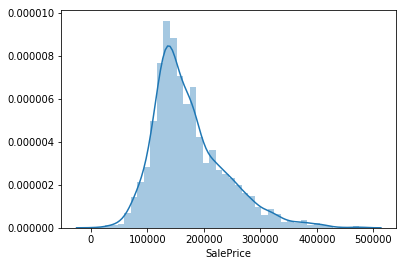

In [12]:
sns.distplot(df_train['SalePrice']);
print("Skewness: %f" % df_train['SalePrice'].skew())

If skewness is less than -1 or greater than 1, the distribution is highly skewed.
If skewness is between -1 and -0.5 or between 0.5 and 1, the distribution is moderately skewed.
If skewness is between -0.5 and 0.5, the distribution is approximately symmetric.

This high skewness can reduce the performance of the ML regression models because some assume normal distribution,
Therfore we make a log transformation, the resulting distribution looks much better.

Skewness: -0.211767


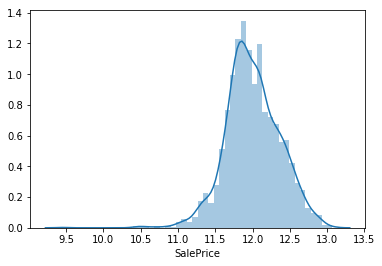

In [13]:
df_train.SalePrice = np.log(df_train.SalePrice);
print("Skewness: %f" % df_train['SalePrice'].skew())
sns.distplot(df_train['SalePrice']);

In [14]:
'''taking log of variables
for df in [df_train, df_test]:
    df['VeneerExterior'] = np.log(df['VeneerExterior'])
    df['OpenPrchSqft'] = np.log(df['OpenPrchSqft'])
    df['BsmtFinSqft'] = np.log(df['BsmtFinSqft'])
'''

"taking log of variables\nfor df in [df_train, df_test]:\n    df['VeneerExterior'] = np.log(df['VeneerExterior'])\n    df['OpenPrchSqft'] = np.log(df['OpenPrchSqft'])\n    df['BsmtFinSqft'] = np.log(df['BsmtFinSqft'])\n"

In [15]:
for col in df_train:
    print('{:15}'.format(col), 
          'Skewness: {:05.2f}'.format(df_train[col].skew())  
         )

YearBuilt       Skewness: -0.57
YearRemodel     Skewness: -0.46
VeneerExterior  Skewness: 02.78
BsmtFinTp       Skewness: -0.90
BsmtFinSqft     Skewness: 00.70
BsmtUnfinSqft   Skewness: 00.88
HeatingQC       Skewness: -0.51
FstFlrSqft      Skewness: 00.80
SecFlrSqft      Skewness: 00.75
AbvGrndLiving   Skewness: 00.77
FullBathBsmt    Skewness: 00.34
HalfBathHouse   Skewness: 00.53
FullBathHouse   Skewness: -0.05
BdrmAbvGrnd     Skewness: -0.09
RmAbvGrnd       Skewness: 00.52
Fireplaces      Skewness: 00.72
GarageTp        Skewness: -0.74
GarageCars      Skewness: -0.23
GarageArea      Skewness: 00.21
WdDckSqft       Skewness: 01.42
OpenPrchSqft    Skewness: 02.16
SalePrice       Skewness: -0.21
LotArea         Skewness: 09.93
LotShape        Skewness: -0.60
BldgTp          Skewness: -2.30
OverallQuality  Skewness: 00.09
OverallCondition Skewness: 00.65


In [16]:
# Find most important features relative to target
print("Find most important features relative to target")
corr = df_train.corr()
corr.sort_values(["SalePrice"], ascending = False, inplace = True)
print(corr.SalePrice)

Find most important features relative to target
SalePrice           1.000000
OverallQuality      0.788644
AbvGrndLiving       0.722013
GarageCars          0.678234
GarageArea          0.644784
YearBuilt           0.618089
FullBathHouse       0.614093
FstFlrSqft          0.613649
YearRemodel         0.550270
RmAbvGrnd           0.519073
GarageTp            0.513398
Fireplaces          0.463648
HeatingQC           0.454256
VeneerExterior      0.377611
BsmtFinSqft         0.364015
OpenPrchSqft        0.322271
HalfBathHouse       0.311851
WdDckSqft           0.295870
LotArea             0.282797
SecFlrSqft          0.276676
FullBathBsmt        0.237126
BdrmAbvGrnd         0.213603
BsmtUnfinSqft       0.158447
BsmtFinTp           0.138838
BldgTp              0.027283
OverallCondition   -0.088469
LotShape           -0.332331
Name: SalePrice, dtype: float64


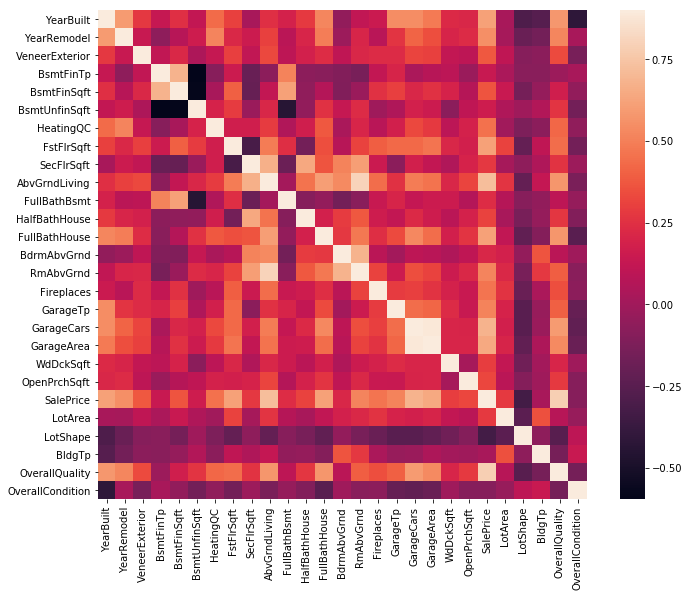

In [17]:
corrmat = df_train.corr()
plt.subplots(figsize=(12,9))
sns.heatmap(corrmat, vmax=0.9, square=True)

Deleting Outliers

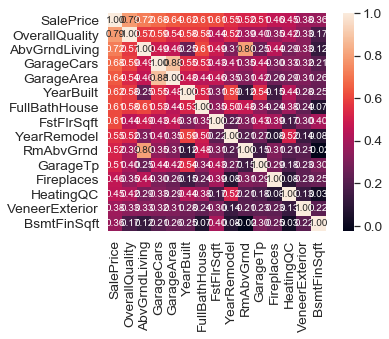

In [18]:
k = 15 #number of variables for heatmap
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(df_train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

Using the heatmaps, we can see which variables are correlated to each other and which variables are more correlated to the SalePrice. This allows us to determine which features we need in our model. For example we can delete those variables which are not correlated to SalePrice in out maps and optimize our models.

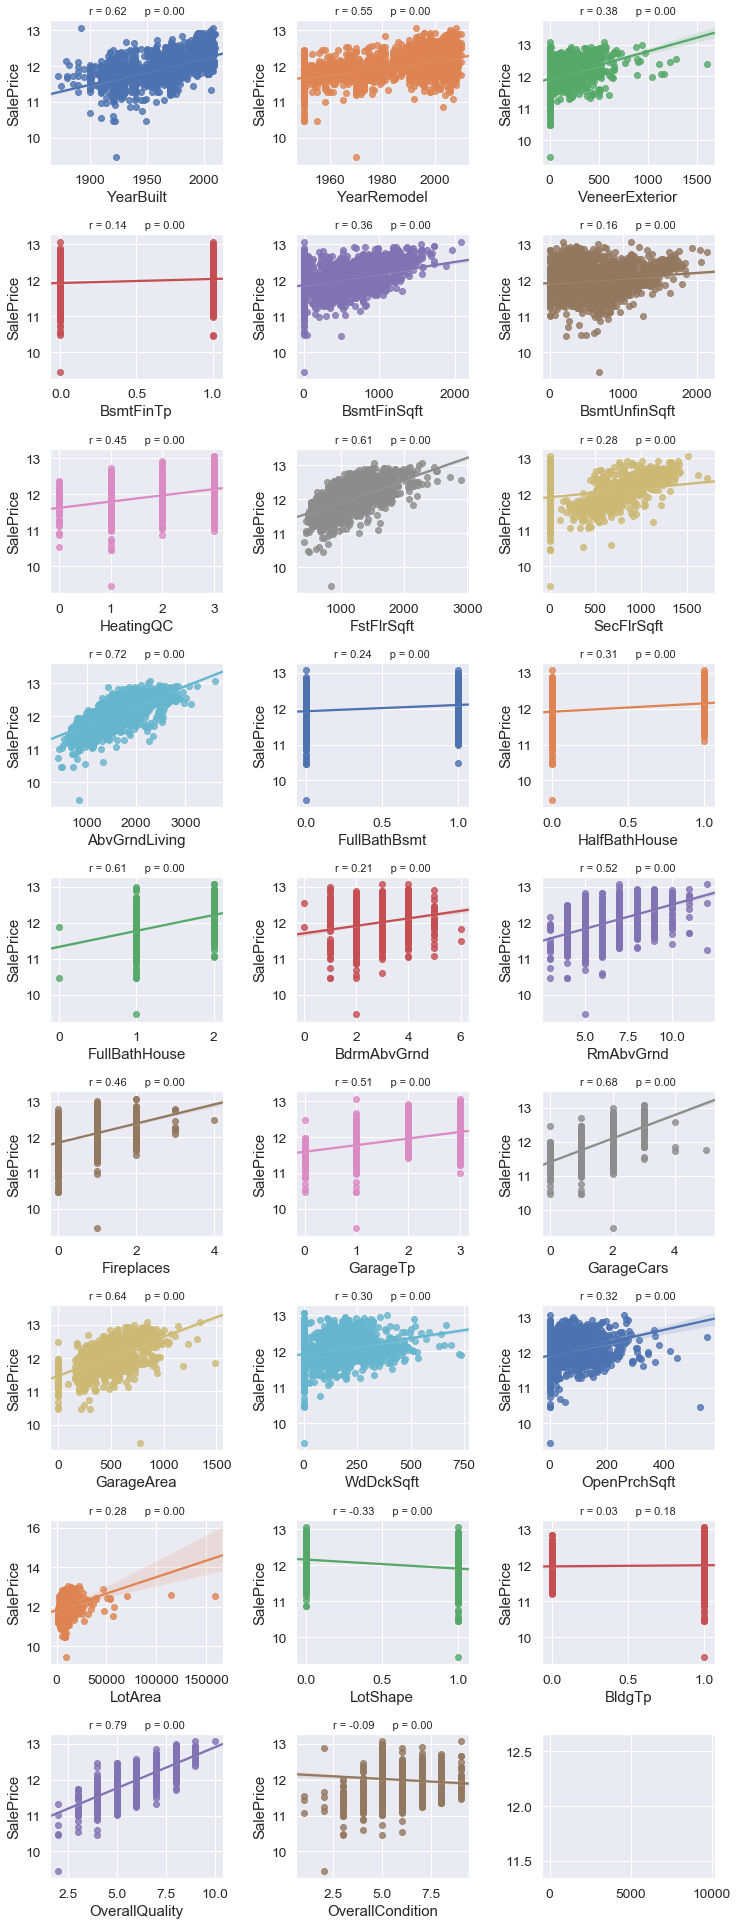

In [19]:
nr_rows = 9
nr_cols = 3

fig, axs = plt.subplots(nr_rows, nr_cols, figsize=(nr_cols*3.5,nr_rows*3))

li_num_feats = list(df_train)
li_not_plot = ['SalePrice']
li_plot_num_feats = [c for c in list(df_train) if c not in li_not_plot]


for r in range(0,nr_rows):
    for c in range(0,nr_cols):  
        i = r*nr_cols+c
        if i < len(li_plot_num_feats):
            sns.regplot(df_train[li_plot_num_feats[i]], df_train['SalePrice'], ax = axs[r][c])
            stp = stats.pearsonr(df_train[li_plot_num_feats[i]], df_train['SalePrice'])
            #axs[r][c].text(0.4,0.9,"title",fontsize=7)
            str_title = "r = " + "{0:.2f}".format(stp[0]) + "      " "p = " + "{0:.2f}".format(stp[1])
            axs[r][c].set_title(str_title,fontsize=11)
            
plt.tight_layout()    
plt.show()   

These graps show in depth detail of every variable's relationship with SalePrice. We are going to keep every variable whose correaltion is greater the 0.3. I found this value by trial and error. Thus, this a is a middle ground where we are not deleting a lot of variables and loosing information, and on the other hand we are not keeping all the varibles and having a negative effect on our model.

# Part 2: Data wrangling

**Drop all columns with only small correlation to SalePrice**  
**Transform Categorical to numerical **  
**Handling columns with missing data**  
**Log values**  
**Drop all columns with strong correlation to similar features** 

Deleting the outliers

In [20]:
df_train = df_train.drop(df_train[(df_train['YearBuilt']>1950) & (df_train['SalePrice']<10)].index)

Dropping all columns with weak correlation to SalePrice. Only columns with strong correlation to target are chosen. In our case, we have dropped the features having less than 0.3 correlation with the SalePrice.

In [21]:
# List of features
feats = list(df_train).copy()
feats.remove('SalePrice')
feats.remove('LotShape')
feats.remove('OverallCondition')
feats.remove('BldgTp')
feats.remove('BsmtFinTp')
feats.remove('BsmtUnfinSqft')
feats.remove('BdrmAbvGrnd')
feats.remove('FullBathBsmt')
feats.remove('LotArea')
feats.remove('SecFlrSqft')
feats.remove('WdDckSqft')

print(feats)

['YearBuilt', 'YearRemodel', 'VeneerExterior', 'BsmtFinSqft', 'HeatingQC', 'FstFlrSqft', 'AbvGrndLiving', 'HalfBathHouse', 'FullBathHouse', 'RmAbvGrnd', 'Fireplaces', 'GarageTp', 'GarageCars', 'GarageArea', 'OpenPrchSqft', 'OverallQuality']


In [22]:
df_train_ml = df_train[feats].copy()
df_test_ml  = df_test[feats].copy()
y = df_train['SalePrice']

In [23]:
sc = StandardScaler()
df_train_ml_sc = sc.fit_transform(df_train_ml)
df_test_ml_sc = sc.transform(df_test_ml)
df_train_ml_sc = pd.DataFrame(df_train_ml_sc)
df_train_ml_sc.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,-0.351157,-1.164190,0.150336,0.511861,-2.281286,1.567525,0.470986,-0.769897,-1.012751,0.532453,2.237915,0.759526,0.396435,0.354417,0.249057,-0.040437
1,-0.317937,-1.115857,-0.555464,0.093454,-1.221990,-0.640431,-1.234949,-0.769897,-1.012751,-0.903987,-0.935198,0.759526,-1.014303,1.376856,-0.716193,-0.839058
2,-0.417595,-1.260856,0.125129,1.206758,-1.221990,0.617523,-0.263015,1.298874,-1.012751,-0.185767,-0.935198,0.759526,-1.014303,-0.738884,-0.155725,-0.040437
3,-0.085403,-0.777527,-0.555464,1.554206,0.896603,2.886488,1.490057,1.298874,0.980787,1.250673,2.237915,0.759526,0.396435,0.324048,-0.716193,0.758185
4,0.877954,0.672459,-0.555464,0.883777,-0.162694,-0.547464,0.410380,1.298874,0.980787,-0.185767,0.651359,0.759526,0.396435,0.121585,-0.186862,-0.839058


In [24]:
X = df_train_ml.copy()
y = df_train['SalePrice']
X_test = df_test_ml.copy()

X_sc = df_train_ml_sc.copy()
y_sc = df_train['SalePrice']
X_test_sc = df_test_ml_sc.copy()

X.info()
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2370 entries, 0 to 2369
Data columns (total 16 columns):
YearBuilt         2370 non-null int64
YearRemodel       2370 non-null int64
VeneerExterior    2370 non-null int64
BsmtFinSqft       2370 non-null int64
HeatingQC         2370 non-null int64
FstFlrSqft        2370 non-null int64
AbvGrndLiving     2370 non-null int64
HalfBathHouse     2370 non-null int64
FullBathHouse     2370 non-null int64
RmAbvGrnd         2370 non-null int64
Fireplaces        2370 non-null int64
GarageTp          2370 non-null int64
GarageCars        2370 non-null int64
GarageArea        2370 non-null int64
OpenPrchSqft      2370 non-null int64
OverallQuality    2370 non-null int64
dtypes: int64(16)
memory usage: 314.8 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 16 columns):
YearBuilt         100 non-null int64
YearRemodel       100 non-null int64
VeneerExterior    100 non-null float64
BsmtFinSqft       100 non-n

In [25]:
X.head()

,YearBuilt,YearRemodel,VeneerExterior,BsmtFinSqft,HeatingQC,FstFlrSqft,AbvGrndLiving,HalfBathHouse,FullBathHouse,RmAbvGrnd,Fireplaces,GarageTp,GarageCars,GarageArea,OpenPrchSqft,OverallQuality
0,1960,1960,112,639,0,1656,1656,0,1,7,2,3,2,528,62,6
1,1961,1961,0,468,1,896,896,0,1,5,0,3,1,730,0,5
2,1958,1958,108,923,1,1329,1329,1,1,6,0,3,1,312,36,6
3,1968,1968,0,1065,3,2110,2110,1,2,8,2,3,2,522,0,7
4,1997,1998,0,791,2,928,1629,1,2,6,1,3,2,482,34,5


In [26]:
y.head()

0    12.278393
1    11.561716
2    12.055250
3    12.404924
4    12.154253
Name: SalePrice, dtype: float64

In [27]:
X_sc.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,-0.351157,-1.164190,0.150336,0.511861,-2.281286,1.567525,0.470986,-0.769897,-1.012751,0.532453,2.237915,0.759526,0.396435,0.354417,0.249057,-0.040437
1,-0.317937,-1.115857,-0.555464,0.093454,-1.221990,-0.640431,-1.234949,-0.769897,-1.012751,-0.903987,-0.935198,0.759526,-1.014303,1.376856,-0.716193,-0.839058
2,-0.417595,-1.260856,0.125129,1.206758,-1.221990,0.617523,-0.263015,1.298874,-1.012751,-0.185767,-0.935198,0.759526,-1.014303,-0.738884,-0.155725,-0.040437
3,-0.085403,-0.777527,-0.555464,1.554206,0.896603,2.886488,1.490057,1.298874,0.980787,1.250673,2.237915,0.759526,0.396435,0.324048,-0.716193,0.758185
4,0.877954,0.672459,-0.555464,0.883777,-0.162694,-0.547464,0.410380,1.298874,0.980787,-0.185767,0.651359,0.759526,0.396435,0.121585,-0.186862,-0.839058


In [28]:
X_test.head()

,YearBuilt,YearRemodel,VeneerExterior,BsmtFinSqft,HeatingQC,FstFlrSqft,AbvGrndLiving,HalfBathHouse,FullBathHouse,RmAbvGrnd,Fireplaces,GarageTp,GarageCars,GarageArea,OpenPrchSqft,OverallQuality
0,2005,2006,226.0,0,3,1595.0,1595,0,2,6.0,1,3,3,880,0,8
1,2009,2010,0.0,0,3,1218.0,1218,0,2,4.0,0,3,2,676,136,7
2,2009,2009,0.0,24,3,764.0,1547,1,2,7.0,0,3,2,614,45,7
3,2006,2006,24.0,686,3,1208.0,1208,0,2,6.0,0,3,2,632,61,7
4,2009,2009,0.0,0,3,1226.0,1226,0,2,6.0,0,3,3,740,36,7


# Part 3: Scikit-learn basic regression models and comparison of results

**Test simple sklearn models and compare by metrics**

**Model tuning and selection with GridSearchCV**

In [29]:
from sklearn.model_selection import GridSearchCV
score_calc = 'neg_mean_squared_error'

### Linear Regression

In [30]:
from sklearn.linear_model import LinearRegression

# setting the number of cross validations used in the Model part
nr_cv = 5
linreg = LinearRegression()
parameters = {'fit_intercept':[True,False], 'normalize':[True,False], 'copy_X':[True, False]}
grid_linear = GridSearchCV(linreg, parameters, cv=nr_cv, verbose=1 , scoring = score_calc)
grid_linear.fit(X, y)

sc_linear = get_best_score(grid_linear)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.13665910180702268
{'copy_X': True, 'fit_intercept': True, 'normalize': False}
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)


[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    0.3s finished


In [31]:
linreg_sc = LinearRegression()
parameters = {'fit_intercept':[True,False], 'normalize':[True,False], 'copy_X':[True, False]}
grid_linear_sc = GridSearchCV(linreg_sc, parameters, cv=nr_cv, verbose=1 , scoring = score_calc)
grid_linear_sc.fit(X_sc, y)

sc_linear_sc = get_best_score(grid_linear_sc)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 8 candidates, totalling 40 fits
0.13665910180702276
{'copy_X': True, 'fit_intercept': True, 'normalize': True}
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)


[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    0.2s finished


In [32]:
linregr_all = LinearRegression()
#linregr_all.fit(X_train_all, y_train_all)
linregr_all.fit(X, y)
pred_linreg_all = linregr_all.predict(X_test)
pred_linreg_all[pred_linreg_all < 0] = pred_linreg_all.mean()

In [33]:
linregr_all = LinearRegression()
#linregr_all.fit(X_train_all, y_train_all)
linregr_all.fit(X, y)

pred_linreg_all = linregr_all.predict(X_test)
pred_linreg_all[pred_linreg_all < 0] = pred_linreg_all.mean()

In [34]:
sub_linreg = pd.DataFrame()
sub_linreg['PID'] = test_pid
sub_linreg['SalePrice'] = np.exp(pred_linreg_all)
sub_linreg.to_csv('linreg.csv',index=False)
sub_linreg.head(10)

,PID,SalePrice
0,528445060,246016.354650
1,528456160,182798.004886
2,528458070,190469.769708
3,906380190,196129.215655
4,906385010,191334.413130
5,906385020,184297.814695
6,528235010,192177.598339
7,528235090,209464.087966
8,528240150,127351.403031
9,528250020,204277.568011


### RandomForestRegressor

In [35]:
from sklearn.ensemble import RandomForestRegressor

param_grid = {'min_samples_split' : [3,4,6,10], 'n_estimators' : [70,100], 'random_state': [5] }
grid_rf = GridSearchCV(RandomForestRegressor(), param_grid, cv=nr_cv, refit=True, verbose=1, scoring = score_calc)
grid_rf.fit(X, y)

sc_rf = get_best_score(grid_rf)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:   60.0s finished


0.14214869717371886
{'min_samples_split': 10, 'n_estimators': 100, 'random_state': 5}
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=10,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=5, verbose=0, warm_start=False)


In [36]:
pred_rf = grid_rf.predict(X_test)

sub_rf = pd.DataFrame()
sub_rf['PID'] = test_pid
sub_rf['SalePrice'] = pred_rf 

sub_rf['SalePrice'] = np.exp(sub_rf['SalePrice']) 

sub_rf.to_csv('rf.csv',index=False)
sub_rf.head()

,PID,SalePrice
0,528445060,243619.733650
1,528456160,208957.351194
2,528458070,190625.931279
3,906380190,191016.698550
4,906385010,208525.682880


### KNN Regressor

In [37]:
from sklearn.neighbors import KNeighborsRegressor

param_grid = {'n_neighbors' : [3,4,5,6,7,10,15] ,    
              'weights' : ['uniform','distance'] ,
              'algorithm' : ['ball_tree', 'kd_tree', 'brute']}

grid_knn = GridSearchCV(KNeighborsRegressor(), param_grid, cv=nr_cv, refit=True, verbose=1, scoring = score_calc)
grid_knn.fit(X_sc, y_sc)

sc_knn = get_best_score(grid_knn)

Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.14956761072401226
{'algorithm': 'brute', 'n_neighbors': 15, 'weights': 'distance'}
KNeighborsRegressor(algorithm='brute', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=None, n_neighbors=15, p=2,
          weights='distance')


[Parallel(n_jobs=1)]: Done 210 out of 210 | elapsed:   44.1s finished


In [38]:
#k1=np.array(X_test_sc)
pred_knn = grid_knn.predict(X_test_sc)#np.nan_to_num(k1))

sub_knn = pd.DataFrame()
sub_knn['PID'] = test_pid
sub_knn['SalePrice'] = pred_knn

sub_knn['SalePrice'] = np.exp(sub_knn['SalePrice']) 

sub_knn.to_csv('knn.csv',index=False)

In [39]:
sub_knn.head(10)

,PID,SalePrice
0,528445060,253729.023685
1,528456160,194260.328323
2,528458070,190066.494813
3,906380190,193414.711605
4,906385010,197581.097443
5,906385020,181759.664974
6,528235010,185655.560317
7,528235090,214037.912651
8,528240150,182831.108669
9,528250020,188405.830521


### Calculating RMSE and comparing models

In [40]:
list_scores = [sc_linear, sc_knn, sc_rf]
list_regressors = ['Linear','KNN', 'RF']

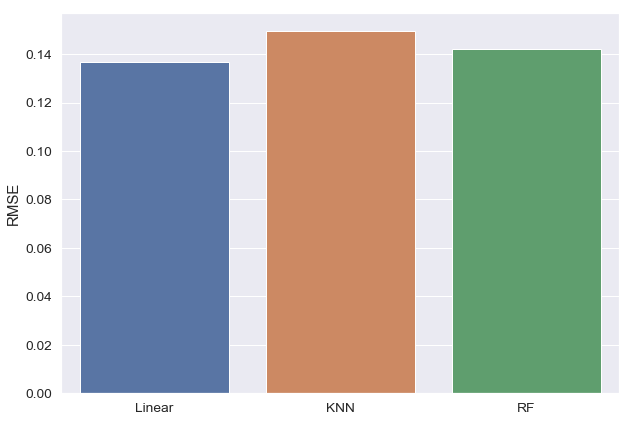

In [41]:
fig, ax = plt.subplots()
fig.set_size_inches(10,7)
sns.barplot(x=list_regressors, y=list_scores, ax=ax)
plt.ylabel('RMSE')
plt.show()

We can verify that Linear and Lasso Regressors give the least errors and then RF and lastly KNN gives the worst results among these.

### Correlation of model results

In [42]:
predictions = {'Linear': pred_linreg_all, 'KNN': pred_knn, 'RF': pred_rf}
df_predictions = pd.DataFrame(data=predictions) 
df_predictions.corr()

,Linear,KNN,RF
Linear,1.000000,0.911952,0.932372
KNN,0.911952,1.000000,0.968552
RF,0.932372,0.968552,1.000000


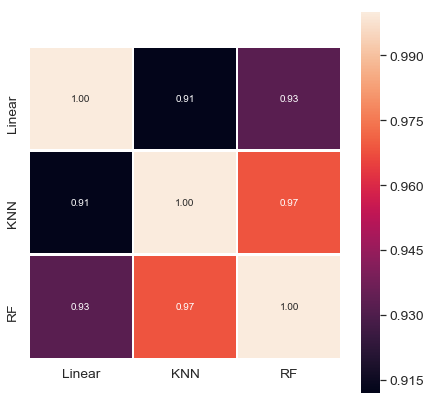

In [43]:
plt.figure(figsize=(7, 7))
sns.set(font_scale=1.25)
sns.heatmap(df_predictions.corr(), linewidths=1.5, annot=True, square=True, 
                fmt='.2f', annot_kws={'size': 10}, 
                yticklabels=df_predictions.columns , xticklabels=df_predictions.columns
            )
plt.show()

**Mean of all 4 models**

In [44]:
sub_mean = pd.DataFrame()
sub_mean['PID'] = test_pid
sub_mean['SalePrice'] = (sub_linreg['SalePrice'] + sub_knn['SalePrice'] + sub_rf['SalePrice']) / 3.0 
sub_mean['SalePrice'] = sub_mean['SalePrice'].astype(float)
sub_mean.to_csv('mean.csv',index=False)

# Conclusion

Throughout this kernel we put in practice many of the models and strategies. We philosophied about the variables, we analysed 'SalePrice' alone and with the most correlated variables, we dealt with missing data and outliers, we tested some of the fundamental statistical assumptions. We also ran various models using different consraints and concluded about the model's results by comparing them. In order to get an average of all the models, we have taken mean of the results and compiled a serparate file for the solution.